# **Non ho niente da dire**
This is a Data Visualization Project about Hong Kong Extradition Protests during 2019-2020. <br/>This project is developed for the final exam of *Information Visualization* course in the *DHDK program* at the *University of Bologna*.<br/>
student name: Zhao Ying

### Table of Contents
- [1. Project Introduction](#1-project-introduction)
  - [1.1 Background](#11-background)
  - [1.2 Goal](#12-goal)
  - [1.3 Research Questions](#13-research-questions)
- [2. Data Preparation](#2-data-preparation)
  - [2.1 Data Description](#21-data-description)
  - [2.2 Data Cleaning](#22-data-cleaning)
- [3. Data Analysis and Visualization](#3-data-analysis-and-visualization)



## 1. Project Introduction

### 1.1 Background
 •	**Domain**: political and social movements.
 
 •	**Context**: On March 15, 2019, Hong Kong started a series of protests against a proposed amendment to the Fugitive Offenders Ordinance, which would allow extradition to mainland China. 
This sparked one of the biggest and longest protest movements in Hong Kong's history, as citizens feared it would threaten the region's autonomy and legal protections.
The protests didn't have a specific end date. Still, for this analysis, I take June 30, 2020, the date when the Hong Kong national security law (created in response to the extradition protests) was enacted, as the conclusion of this period. 
In the end, the extradition bill was withdrawn, but the Chinese government tightened its unprecedented control over Hong Kong since 1997. The introduction of the national security law symbolized a significant reduction in Hong Kong’s autonomy.

 
### 1.2 Goal
My goal is to compare the extradition protests with other protests in Hong Kong during the same period to identify unique features of the extradition protests. Additionally, I want this project to be seen as a comprehensive archive to record the 2019-2020 protests. 

### 1.3 Research Questions
 <ol>
  <li> <strong>How</strong> do the extradition protests <strong>compare</strong> to other protests during <strong>the same period</strong>?</li>
  <li> <strong>Where</strong> were the protests <strong>geographically</strong> concentrated?</li> 
  <li> <strong>What</strong> were the most frequent <strong>terms</strong> during this period?</li> 
</ol>


## 2. Data Preparation

### 2.1 Data Description

The datasets for this project are from WikiData and ACLED.<br>

**ACLED Dataset**: The ACLED (Armed Conflict Location & Event Data) platform is a comprehensive collection of data on political violence and protest events in the world.  After reviewing many dataset platforms,  I found that this one had the most suitable and well-structured data for the project. I used *ACLED's data export tool* to obtain data specific to China from March 15, 2019, to June 30, 2020. 

**WikiData Dataset**: Wikidata is a linked open data platform that provides structured data to support Wikipedia and other Wikimedia projects. Compared to other linked open data platforms, Wikidata has the most data on the Hong Kong Extradition Protests, with less missing entries. For this project, I used SPASQL to query Wikidata on every event which is part of the Hong Kong Extradition Protests(*wd:Q64509602*), since this entity represents the Extradition Protests.

Given the features of the two datasets — the comprehensiveness of the ACLED dataset and the limitations of the Wikidata dataset — I primarily use the ACLED dataset for data analysis and the Wikidata dataset to cross-verify the ACLED data and discover frequent items. 


### 2.2 Data Cleaning
#### 2.2.1 ACLED Dataset

After reviewing the csv file. I found out that the dataset is well structured, doesn't have many missing values. In this step, what i did are:<br/>
 •	**Filtered** the dataset to only include protests happened in Hong Kong.<br/>
 •	**Converted the time format** to numeral for further filters and analyze.<br/>
 •	Checked missing values, **removed irrelevant, and repetitive columns**. and filled in ones are useful to the project.<br/>
 •	**Converted** values in location to a standardised format. 

   The **reasons** for removing specific columns:<br/>
   •	*actor2* and *assoc_actor_2*:  These columns have a large amount of missing values (544 and 108 out of 3139) and are not important for the analysis.<br/>
   •	*civilian_targeting*:  This column contains only 26 values, describing individual attacks with unknown purpose, which are not the focus of this project. <br/>
   •	*admin2*:  The values in this column are redundant as they are the same as those in the *location* column.<br/>
   •  *admin3*:  This column represents more specific locations names but has about 2/3 of its values missing, and i can use *latitude* and *longitude* to achieve the same effect.

In [48]:
import pandas as pd
df_protests_2019_2020 = pd.read_csv("data/2019-03-15-2020-06-30-East_Asia-China.csv" )

# Filter data for Hong Kong
df_hk_2019_2020 = df_protests_2019_2020[df_protests_2019_2020['location'].str.contains('Hong Kong', case=False, na=False)]

# Convert the date column to numeral format
df_hk_2019_2020['event_date'] = pd.to_datetime(df_hk_2019_2020['event_date'], format='%d %B %Y', errors='coerce')

# Remove irrelevant columns
df_hk_2019_2020_cleaned = df_hk_2019_2020.drop(columns=['actor2', 'assoc_actor_2', 'civilian_targeting', 'admin2', 'admin3'])

# Function to standardise the 'location' column
def stand_location(location):
    if pd.isnull(location) or location.strip().lower() == 'hong kong': #since some values only have 'hong kong' which don't show the region part and already exist in 'admin1'
        return 'unknown'
    else:
        # Split the string and return only the administrative region part
        parts = location.split('-')
        if len(parts) > 1:
            return parts[1].strip()
        else:
            return 'unknown'

df_hk_2019_2020_cleaned['location'] = df_hk_2019_2020_cleaned['location'].apply(stand_location)

#uncomment to check the result
#print(df_hk_2019_2020_cleaned.info())
#print(df_hk_2019_2020_cleaned.head(10))

C:\Users\ge75\AppData\Local\Temp\ipykernel_7884\2518450520.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_hk_2019_2020['event_date'] = pd.to_datetime(df_hk_2019_2020['event_date'], format='%d %B %Y', errors='coerce')


For answering the main question, It is important to distinguish events related to Extradition Protests from those that are not. The battle cry of the whole protests, **the five demands**, which frequently appear in the dataset. After viewing the dataset, i discovered that **five demands moment** is also a common value in *assoc_actor_1*. Therefore, i checked if *assoc_actor_1* contains this value and also searched specific keywords in *notes* to create a new column to achieve the aim. 

In [49]:
# Create a function to distinguish if an event related to extradition protests
def has_five_demands_movement(row):
    keywords = [ "Extradition Bill", "Five Demands"]
    assoc_actor = str(row['assoc_actor_1']) if not pd.isnull(row['assoc_actor_1']) else ""  # iterate over each row 
    notes = str(row['notes'])

    if 'Five Demands Movement' in assoc_actor or any(keyword in notes for keyword in keywords): 
        return 'yes'
    elif pd.isnull(row['assoc_actor_1']):  #assoc_actor has a missing value and no keywords were found in notes
        return 'unknown'
    else:
        return 'no' #assoc_actor has a different value and no keywords were found in notes
    
df_hk_2019_2020_cleaned['related_ep'] = df_hk_2019_2020_cleaned.apply(has_five_demands_movement, axis=1) #apply the function row-wise

# Fill missing values in 'assoc_actor_1' with 'Unknown'
df_hk_2019_2020_cleaned['assoc_actor_1'].fillna('Unknown', inplace=True)


# uncomment to check the result
#df_hk_2019_2020_cleaned[['assoc_actor_1','related_ep','notes']]

C:\Users\ge75\AppData\Local\Temp\ipykernel_7884\632714736.py:17: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_hk_2019_2020_cleaned['assoc_actor_1'].fillna('Unknown', inplace=True)


I reviewed the CSV file to understand the meanings of values of the *event_types* and *sub_-_event_types*. <br/>
Under the *Riots* category, there are *Violent demonstration* and *Mob violence*. Since  *Mob violence* events are typically anonymous with unclear intentions and involve only a few individuals, I couldn't tell if they are part of any protests. I decided to remove these events from the analysis.

In [50]:
#uncomment to check events_type
unique_event_types = df_hk_2019_2020_cleaned['event_type'].unique()
unique_sub_event_types = df_hk_2019_2020_cleaned['sub_event_type'].unique()
#print(unique_event_types)
#print(unique_sub_event_types)

hk_protests_type_cleaned = df_hk_2019_2020_cleaned[
     (df_hk_2019_2020_cleaned['event_type'] == 'Protests') |
    ((df_hk_2019_2020_cleaned['event_type'] == 'Riots') & (df_hk_2019_2020_cleaned['sub_event_type'] == 'Violent demonstration'))
]


#print(hk_protests_type_cleaned.info())
#print(hk_protests_ACLED.head(10))

hk_protests_type_cleaned.to_csv("data/hk_protests_ACLED.csv")


#### 2.2.2 LOD Dataset

For the LOD dataset, I queried data from Wikidata using **SPARQL** .

the datasets better to include *'people', 'places', 'organizations', or 'dates'*. Since Wikidata doesn't have much data on the extradition protests, I used many OPTIONAL clauses in the query to get as much data as possible.

In [51]:
import rdflib
from SPARQLWrapper import SPARQLWrapper, JSON#
from rdflib import Namespace

wd = Namespace("http://www.wikidata.org/entity/")
wdt = Namespace("http://www.wikidata.org/prop/direct/")

# Set the wikidata endpoint
sparql_wd = SPARQLWrapper("https://query.wikidata.org/sparql")

query ="""
SELECT ?event ?eventLabel ?relatedEntity ?relatedEntityLabel ?relation ?relationLabel ?coordinateLocation ?date WHERE {
  ?event wdt:P361 wd:Q64509602.  
  OPTIONAL {
    ?event ?relation ?relatedEntity.  
    VALUES ?type { wd:Q5 wd:Q43229}  # Human, Organization, Event, Place, Work of Art
    ?relatedEntity wdt:P31 ?type.
  }
  OPTIONAL { ?event wdt:P585 ?date. }
  OPTIONAL { ?event wdt:P625 ?coordinateLocation. } 
  # Get labels for entities and relations
  SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". }
}
ORDER BY ?date
"""

sparql_wd.setQuery(query)
sparql_wd.setReturnFormat(JSON)
results = sparql_wd.query().convert()

#After processing the query in the Wikidata Query Service, I obtained only 77 results, 
# so I decided not to manipulate the results at this step.
LOD_data = []
for result in results["results"]["bindings"]:
    row = {key: result[key]["value"] for key in result}
    LOD_data.append(row)

LOD_data = pd.DataFrame(LOD_data)

print(LOD_data.head())
print(LOD_data.info())


                                      event  \
0  http://www.wikidata.org/entity/Q65315561   
1  http://www.wikidata.org/entity/Q66103022   
2  http://www.wikidata.org/entity/Q66116076   
3  http://www.wikidata.org/entity/Q66711913   
4  http://www.wikidata.org/entity/Q67635900   

                                          eventLabel  \
0  hunger strike against extradition bill in Hong...   
1                                          Q66103022   
2                  2019 MTR non-cooperation movement   
3                         2019 Hong Kong Lennon Wall   
4       2019 Hong Kong International Airport protest   

                  coordinateLocation date relation relatedEntity  \
0                                NaN  NaN      NaN           NaN   
1  Point(114.003055555 22.460277777)  NaN      NaN           NaN   
2                                NaN  NaN      NaN           NaN   
3                                NaN  NaN      NaN           NaN   
4  Point(113.924402274 22.302275979)  Na

After reviewing the LOD_data, it is clear that many values were missing or unusable. <br/>
I did the following steps to address these issues: <br/>

1. Some results only had an value of *eventLabel*, and it's the same as the unique identifier. so I decided to delete them. since they could be problems for further analyze.<br/>
2. Deleted the row *Q77044939*, since it was a list of all protests on December 2019. <br/>
3. There were 15 missing values in the *date* column. I filled in two gaps with date after researching news sources. 
<br/>and the others have periods or multiple dates or were not events, so i just keep them.<br/>
4. Split the *coordinateLocation* into *latitude* and *longitude* columns, like the ACLED dataset, so that I can use them for cross-verification.<br/>

In [52]:
import re
#1:
def if_not_contain_label(row):
    return row['eventLabel'] not in row['event']
LOD_data = LOD_data[LOD_data.apply(if_not_contain_label, axis=1)]#row wise

#2:
drop_value = LOD_data[LOD_data['event'].str.contains('Q77044939')].index
LOD_data = LOD_data.drop(drop_value) #it's a List of December 2019 Hong Kong protests 

#3：
missing_date = LOD_data[LOD_data['date'].isnull()]
#print(missing_date) 
#so i could check the index of them

data_map = {# only two entities have specific dates, other have periods or multiple dates etc
    0: '03 July 2019',  
    10:'04 October 2019',
}

def fill_missing_dates(row):
    if pd.isnull(row['date']):
        return data_map.get(row.name, row['date'])
    return row['date']
LOD_data['date'] = LOD_data.apply(fill_missing_dates, axis=1)

#4：
def split_coordinates(coordinate):
    if isinstance(coordinate, str):  # Ensure coord is a string
        match = re.search(r'Point\(([\d\.]+) ([\d\.]+)\)', coordinate)
        if match:
            longitude, latitude = match.groups()
            return float(latitude), float(longitude)
    return None, None

LOD_data[['latitude', 'longitude']] = LOD_data['coordinateLocation'].apply(lambda x: pd.Series(split_coordinates(x)))
LOD_data['latitude'] = LOD_data['latitude'].round(4)
LOD_data['longitude']= LOD_data['longitude'].round(4)
LOD_data = LOD_data.drop(columns='coordinateLocation')

print(LOD_data.info())
#print(LOD_data.head(10))

LOD_data.to_csv("data/hk_protests_wiki.csv")

<class 'pandas.core.frame.DataFrame'>
Index: 69 entries, 0 to 76
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   event               69 non-null     object 
 1   eventLabel          69 non-null     object 
 2   date                60 non-null     object 
 3   relation            5 non-null      object 
 4   relatedEntity       5 non-null      object 
 5   relatedEntityLabel  5 non-null      object 
 6   relationLabel       5 non-null      object 
 7   latitude            41 non-null     float64
 8   longitude           41 non-null     float64
dtypes: float64(2), object(7)
memory usage: 5.4+ KB
None


#### 2.2.3 Cross-verification
The attempt in section 2.2.3 was unsuccessful, but I've kept it for documentation or further updates.<br/>
I merged ACLED dataset and LOD dataset to **cross-verify**. 

In [46]:
df_acled = pd.read_csv('data/hk_protests_ACLED.csv')

# I've transferred this before, but the Dtype of 'event_date' sometimes become 'Object'. in case it happens again, I repeated the process.
df_acled['event_date'] = pd.to_datetime(df_acled['event_date']) 
LOD_data['date'] = pd.to_datetime(LOD_data['date'],format='%d %B %Y', errors='coerce')
LOD_data['event_date'] = LOD_data['date'].dt.tz_localize(None)  

#since the latitude and longitude have four decimal places.
LOD_data['latitude'] = LOD_data['latitude'].round(4)
LOD_data['longitude']= LOD_data['longitude'].round(4)

#print(df_acled.head())
#print(LOD_data.head())

verified_time = pd.merge(df_acled, LOD_data, on=['event_date'], how='inner')
verified_coordinate = pd.merge(df_acled, LOD_data, on=['event_date','latitude', 'longitude'], how='inner')
#print(verified_time.head())
#print(verified_coordinate.head())

Due to the ACLED dataset's detailedness, it records multiple protests/events occurring on a single day. However, the LOD dataset is less comprehensive, often recording only one protest per day. I could only manually cross-check and match events between the two datasets in such cases.<br/>

As for the coordinates, even after rounding the latitude and longitude values in the LOD dataset, they had 0 matches with those in the ACLED dataset. Upon further using Google Maps, I found that these locations were super close, so I believed that they referred to the same places.

## 3. Data Analysis and Visualization

For answering questions, first, I used pandas_profiling to generate a report for a overview.I checked all the alerts, related columns and the [codebook from ACLED](https://acleddata.com/knowledge-base/codebook/#interaction-codes). Figuring out they are entirely irrelevant to my analyze.

In [47]:
import pandas_profiling as pp
pp.ProfileReport(df_acled)

C:\Users\ge75\AppData\Local\Temp\ipykernel_7884\1768634391.py:1: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.
  import pandas_profiling as pp


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

For answering the first question, I compared values related to  extradition protests and ones are not in different ways.

In [54]:
df_ep = df_acled[df_acled['related_ep'] == 'yes']
df_non_ep = df_acled[df_acled['related_ep'] == 'no']

I used Seaborn to create bar plots to compare event types and sub-event types, since I was comparing a few categories among items.

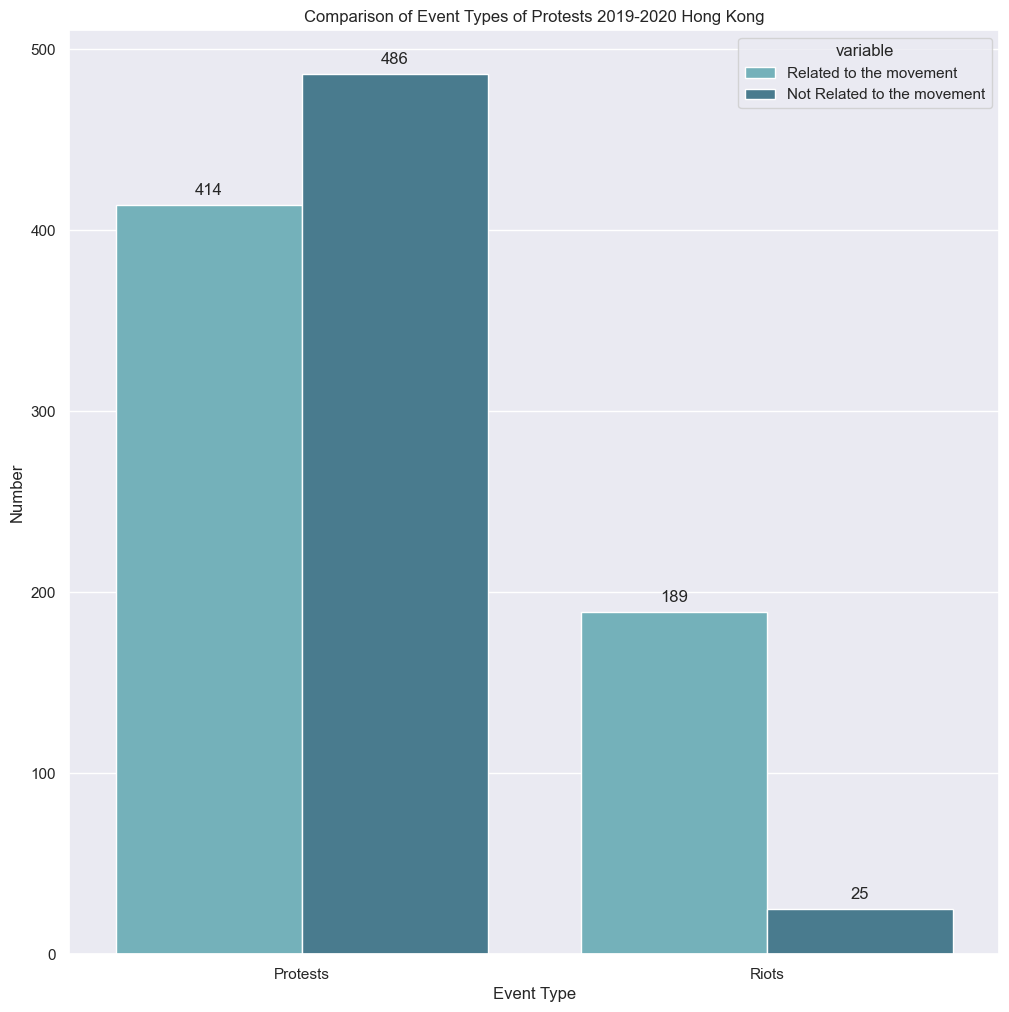

In [56]:
import matplotlib.pyplot as plt
import seaborn as sns

df_data_types = df_ep['event_type'].value_counts().reset_index()
df_data_types.columns = ['event_type', 'Related to the movement']

df_data_non_types = df_non_ep['event_type'].value_counts().reset_index()
df_data_non_types.columns = ['event_type', 'Not Related to the movement']

merge_types = pd.merge(df_data_types, df_data_non_types, on='event_type')

#reshape the DF so i can have number as a column
melt_type = merge_types.melt(id_vars='event_type', value_vars=['Related to the movement', 'Not Related to the movement'], value_name="number")

sns.set_theme(rc={'figure.figsize':(12,12)})
ax = sns.barplot(data=melt_type, x='event_type', y='number', hue='variable', palette="GnBu_d")

for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{int(height)}', 
                (p.get_x() + p.get_width() / 2., height), ha='center', va='bottom', xytext=(0, 5), textcoords='offset points')

plt.title('Comparison of Event Types of Protests 2019-2020 Hong Kong')
plt.xlabel('Event Type')
plt.ylabel('Number')

plt.show()

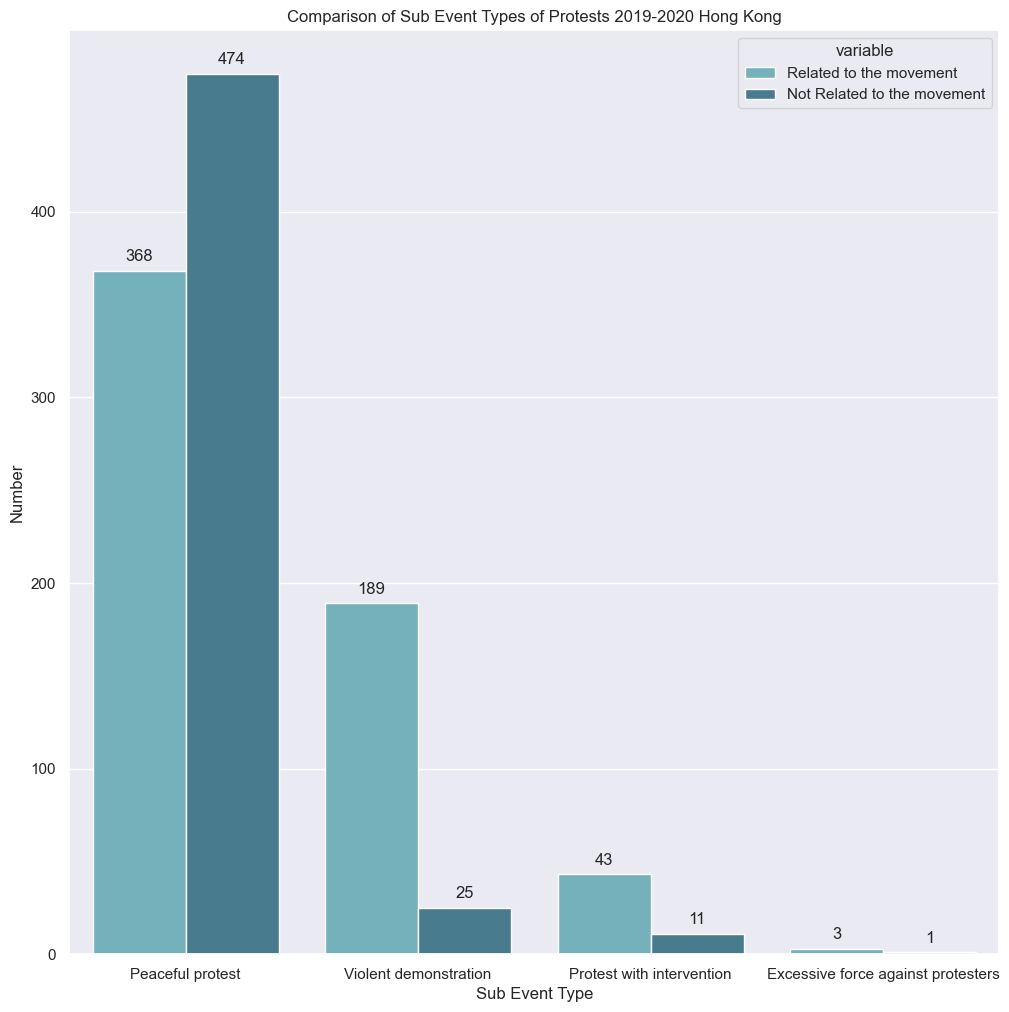

In [57]:
df_data_sub_types = df_ep['sub_event_type'].value_counts().reset_index()
df_data_sub_types.columns = ['sub_event_type', 'Related to the movement']
df_data_non_sub_types = df_non_ep['sub_event_type'].value_counts().reset_index()
df_data_non_sub_types.columns = ['sub_event_type', 'Not Related to the movement']

merge_sub_types = pd.merge(df_data_sub_types , df_data_non_sub_types, on='sub_event_type')
melt_sub_type = merge_sub_types.melt(id_vars='sub_event_type', value_vars=['Related to the movement', 'Not Related to the movement'],value_name="number")

sns.set_theme(rc={'figure.figsize':(12,12)})
ax = sns.barplot(data=melt_sub_type, x='sub_event_type', y='number', hue='variable', palette="GnBu_d")

for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{int(height)}', 
                (p.get_x() + p.get_width() / 2., height), ha='center', va='bottom', xytext=(0, 5), textcoords='offset points')
    
plt.title('Comparison of Sub Event Types of Protests 2019-2020 Hong Kong')
plt.xlabel('Sub Event Type')
plt.ylabel('Number')

plt.show()

Then, I analyzed the time trend of two subtypes of two events using line charts.

C:\Users\ge75\AppData\Local\Temp\ipykernel_7884\3317656761.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_peaceful_related['event_date'] = pd.to_datetime(df_peaceful_related['event_date'])
C:\Users\ge75\AppData\Local\Temp\ipykernel_7884\3317656761.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_peaceful_not_related['event_date'] = pd.to_datetime(df_peaceful_not_related['event_date'])
d:\programming shit\python\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is 

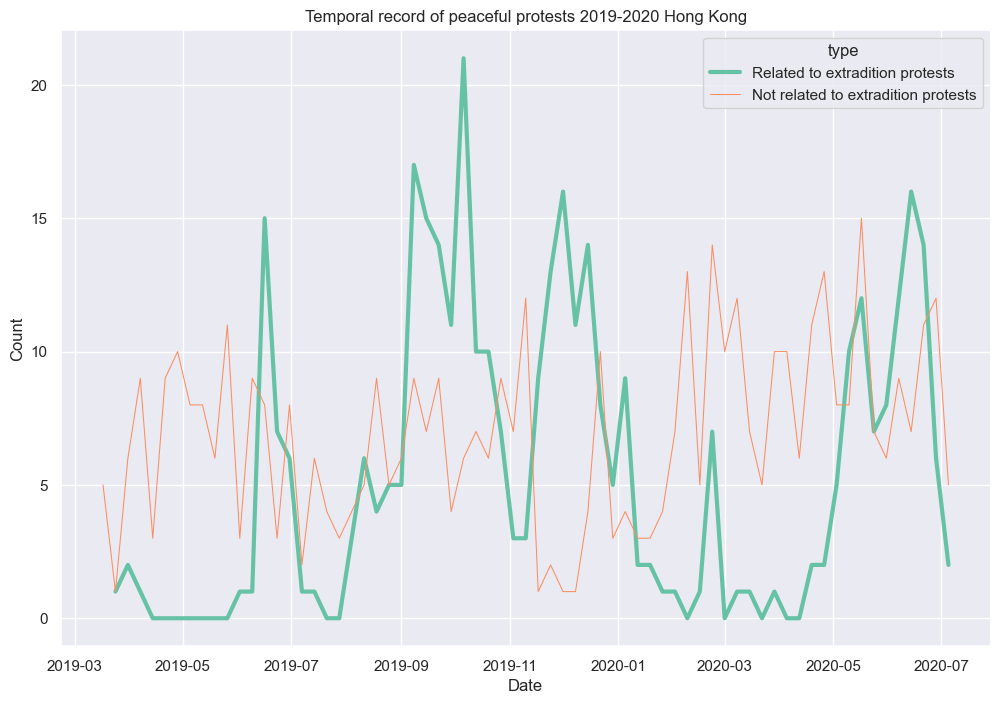

In [58]:
df_peaceful_related = df_acled[(df_acled['sub_event_type'] == 'Peaceful protest') & (df_acled['related_ep'] == 'yes')]
df_peaceful_not_related = df_acled[(df_acled['sub_event_type'] == 'Peaceful protest') & (df_acled['related_ep'] == 'no')]
df_peaceful_related['event_date'] = pd.to_datetime(df_peaceful_related['event_date'])
df_peaceful_not_related['event_date'] = pd.to_datetime(df_peaceful_not_related['event_date'])
df_peaceful_related.set_index('event_date', inplace=True)
df_peaceful_not_related.set_index('event_date', inplace=True)

#data by week
peaceful_related_weekly = df_peaceful_related.resample('W').size().reset_index(name='count')
peaceful_not_related_weekly = df_peaceful_not_related.resample('W').size().reset_index(name='count')
peaceful_related_weekly['type'] = 'Related to extradition protests'
peaceful_not_related_weekly['type'] = 'Not related to extradition protests'

plt.figure(figsize=(12, 8))
sns.lineplot(x='event_date', y='count', data=pd.concat([peaceful_related_weekly, peaceful_not_related_weekly]), hue='type', palette="Set2", size='type')
plt.xlabel('Date')
plt.ylabel('Count')
plt.title('Temporal record of peaceful protests 2019-2020 Hong Kong')
plt.show()

C:\Users\ge75\AppData\Local\Temp\ipykernel_7884\1530023083.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_violent_related['event_date'] = pd.to_datetime(df_violent_related['event_date'])
C:\Users\ge75\AppData\Local\Temp\ipykernel_7884\1530023083.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_violent_not_related['event_date'] = pd.to_datetime(df_violent_not_related['event_date'])
d:\programming shit\python\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is depr

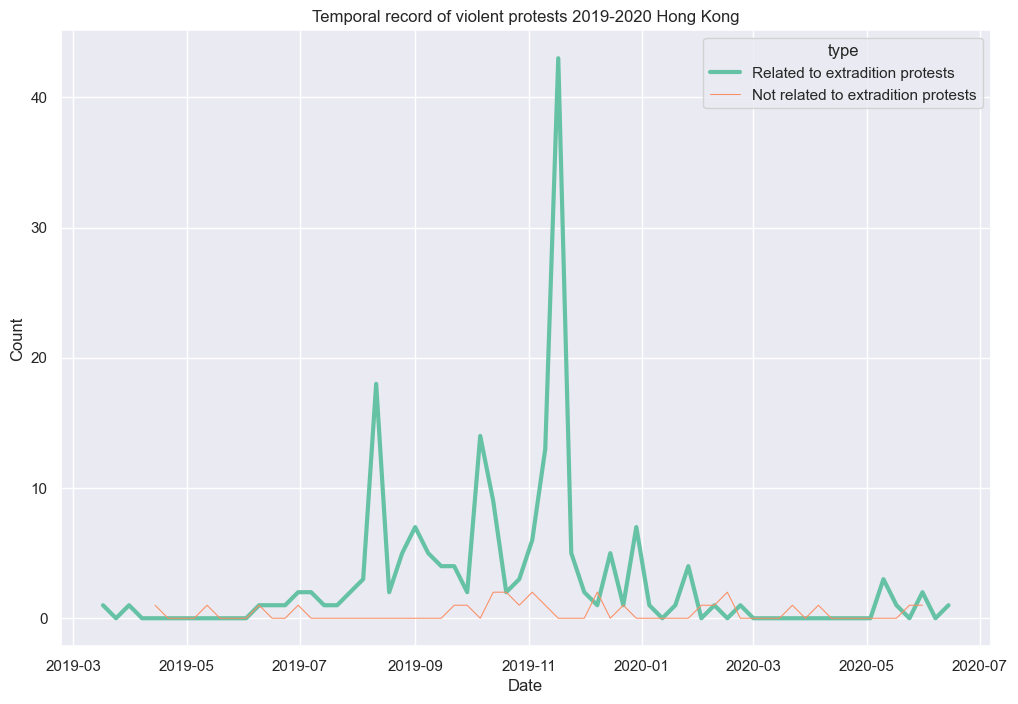

In [59]:
df_violent_related = df_acled[(df_acled['sub_event_type'] == 'Violent demonstration') & (df_acled['related_ep'] == 'yes')]
df_violent_not_related = df_acled[(df_acled['sub_event_type'] == 'Violent demonstration') & (df_acled['related_ep'] == 'no')]
df_violent_related['event_date'] = pd.to_datetime(df_violent_related['event_date'])
df_violent_not_related['event_date'] = pd.to_datetime(df_violent_not_related['event_date'])
df_violent_related.set_index('event_date', inplace=True)
df_violent_not_related.set_index('event_date', inplace=True)

#data by week
violent_related_weekly = df_violent_related.resample('W').size().reset_index(name='count')
violent_not_related_weekly = df_violent_not_related.resample('W').size().reset_index(name='count')
violent_related_weekly['type'] = 'Related to extradition protests'
violent_not_related_weekly['type'] = 'Not related to extradition protests'

plt.figure(figsize=(12, 8))
sns.lineplot(x='event_date', y='count', data=pd.concat([violent_related_weekly, violent_not_related_weekly]), hue='type', palette="Set2", size='type')
plt.xlabel('Date')
plt.ylabel('Count')
plt.title('Temporal record of violent protests 2019-2020 Hong Kong')
plt.show()

To answer the second question: Where were the protests geographically concentrated? I needed a map to visualize the number of protests by different administrative regions. This map is a GeoJSON file for Hong Kong administrative regions on DATA.GOV.HK.

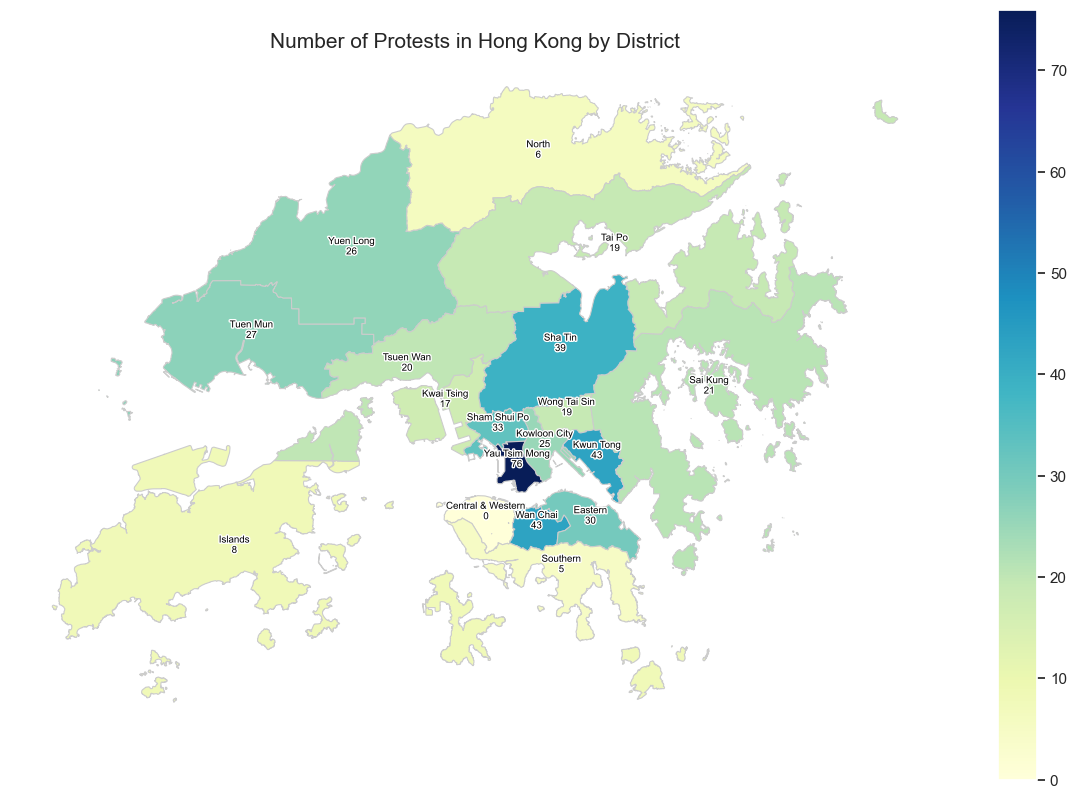

<Figure size 1200x1200 with 0 Axes>

In [60]:
#pip install folium geopandas
import geopandas as gpd
import matplotlib.patheffects as PathEffects

# Load a GeoJSON file for Hong Kong administrative regions 
geojson_path = 'data/Hong_Kong_18_Districts.geojson'  
geo_data = gpd.read_file(geojson_path)

geo_data['ENAME'] = geo_data['ENAME'].str.title()

protest_counts = df_ep['location'].value_counts().reset_index()
protest_counts.columns = ['location', 'count']

geo_data = geo_data.rename(columns={"ENAME": "location"})
merged = geo_data.set_index('location').join(protest_counts.set_index('location'))

# Fill NaN values with 0 for districts with no protests
merged['count'] = merged['count'].fillna(0)

fig, ax = plt.subplots(1, 1, figsize=(15, 10))
merged.plot(column='count', cmap='YlGnBu', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)

plt.title('Number of Protests in Hong Kong by District', fontsize=15)

# Add labels
for idx, row in merged.iterrows():
    text = plt.text(row.geometry.centroid.x, row.geometry.centroid.y, 
             f"{row.name}\n{int(row['count'])}", 
             horizontalalignment='center', fontsize=7, color='black')
    text.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='white')])

# Remove axis to focus on the map
ax.set_axis_off()
plt.show()

Although the data retrieved from Wikidata is limited, I decided to use it as a small sample to provide an overview. Since it contains only key events, the *'eventLabel'* values represent the titles of these significant events.<br/>
Therefore,  I generated a word cloud to identify the most frequent elements associated with the protests.

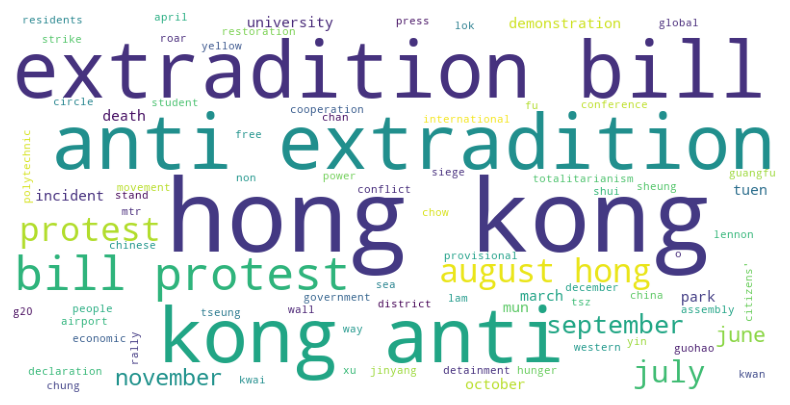

In [35]:
from wordcloud import WordCloud, STOPWORDS

comment_words = ''
stopwords = set(STOPWORDS)

for val in LOD_data.eventLabel:
    val = str(val)
    tokens = val.split()
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
    
    comment_words += " ".join(tokens) + " "

wordcloud = WordCloud(width = 800, height = 400,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(comment_words)


# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()